In [1]:
#Import Libraries
from google.colab import files
import pandas
import numpy as np
import matplotlib.pyplot as plt
import io
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import *
from sklearn.model_selection import KFold
from mpl_toolkits import mplot3d
from keras.optimizers import Adam
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2
import time

In [2]:
#define the Kirsch stress solution
def sigt(sigref, a, r, theta):
  sigmatheta = 0.5*sigref*(1+(a/r)**2) - 0.5*sigref*(1+3*(a/r)**4)*np.cos(2*theta*np.pi/180)
  return sigmatheta

#function to assign variables 
def assign_var(df0):
  y0 = np.array(df0['Y'][:])
  x0 = np.array(df0['X'][:])
  S220 = np.array(df0['S-S22'][:])
  return y0, x0, S220

#filtering function
def filter(df, R):
  df = df[(df['Y'] <= 0.25) & (df['Y'] >= -0.25) & ((df['X'] > R) | (df['X'] < -R))]
  return df

In [3]:
#read in the FEA data
df0 = pandas.read_csv('Report0.csv')
df1 = pandas.read_csv('Report1.csv')
df2 = pandas.read_csv('Report2.csv')
df3 = pandas.read_csv('Report3.csv')
df4 = pandas.read_csv('Report4.csv')
df5 = pandas.read_csv('Report5.csv') 

In [4]:
#Apply the filtering function to reduce data
df0 = filter(df0, 10)
df1 = filter(df1, 20)
df2 = filter(df2, 30)
df3 = filter(df3, 40)
df4 = filter(df4, 50)
df5 = filter(df5, 60)
print(df1.columns.tolist())

['X', 'Y', 'S-S22']


In [5]:
#assign the variables
y0, x0, S220 = assign_var(df0)
y1, x1, S221 = assign_var(df1)
y2, x2, S222 = assign_var(df2)
y3, x3, S223 = assign_var(df3)
y4, x4, S224 = assign_var(df4)
y5, x5, S225 = assign_var(df5)


In [6]:
#define the radii to be used
a = np.linspace(10,60,6)
#use theta = 90
theta = 90
#reference stress of 1
sigref = 1

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/400
4/4 [==============================] - 2s 95ms/step - loss: 1.8261 - val_loss: 2.5687
Epoch 2/400
4/4 [==============================] - 0s 27ms/step - loss: 1.5944 - val_loss: 2.3011
Epoch 3/400
4/4 [==============================] - 0s 20ms/step - loss: 1.4211 - val_loss: 2.0669
Epoch 4/400
4/4 [==============================] - 0s 18ms/step - loss: 1.2791 - val_loss: 1.8560
Epoch 5/400
4/4 [==============================] - 0s 23ms/step - loss: 1.1537 - val_loss: 1.6734
Epoch 6/400
4/4 [==============================] - 0s 40ms/step - loss: 1.0405 - val_loss: 1.5222
Epoch 7/400
4/4 [==============================] - 0s 25ms/step - loss: 0.9677 - val_loss: 1.3827
Epoch 8/400
4/4 [==============================] - 0s 17ms/step - loss: 0.8868 - val_loss: 1.2680
Epoch 9/400
4/4 [==============================] - 0s 13ms/step - loss: 0.8233 - val_loss: 1.1682
Epoch 10/400
4/4 [==============================] - 0s 12ms/step - loss: 0.7743 - val_loss: 1.0789
Epoch 11/400
4/4 [=

2/2 [==============================] - 0s 2ms/step
Epoch 1/400
4/4 [==============================] - 1s 53ms/step - loss: 1.9745 - val_loss: 3.2226
Epoch 2/400
4/4 [==============================] - 0s 10ms/step - loss: 1.9554 - val_loss: 3.2049
Epoch 3/400
4/4 [==============================] - 0s 10ms/step - loss: 1.9412 - val_loss: 3.1850
Epoch 4/400
4/4 [==============================] - 0s 10ms/step - loss: 1.9265 - val_loss: 3.1637
Epoch 5/400
4/4 [==============================] - 0s 11ms/step - loss: 1.9086 - val_loss: 3.1436
Epoch 6/400
4/4 [==============================] - 0s 11ms/step - loss: 1.8972 - val_loss: 3.1260
Epoch 7/400
4/4 [==============================] - 0s 10ms/step - loss: 1.8822 - val_loss: 3.1110
Epoch 8/400
4/4 [==============================] - 0s 12ms/step - loss: 1.8706 - val_loss: 3.0940
Epoch 9/400
4/4 [==============================] - 0s 11ms/step - loss: 1.8595 - val_loss: 3.0773
Epoch 10/400
4/4 [==============================] - 0s 10ms/step - 

2/2 [==============================] - 0s 8ms/step


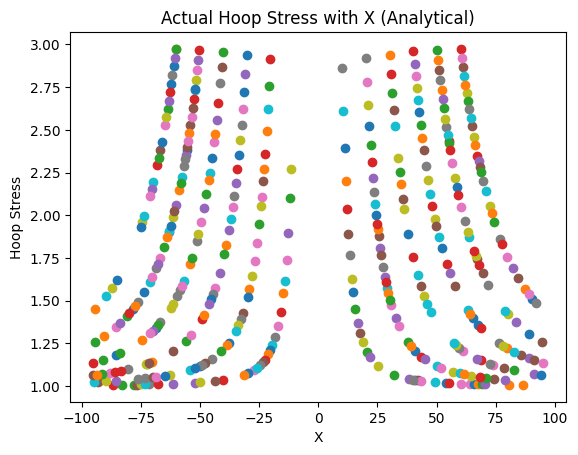

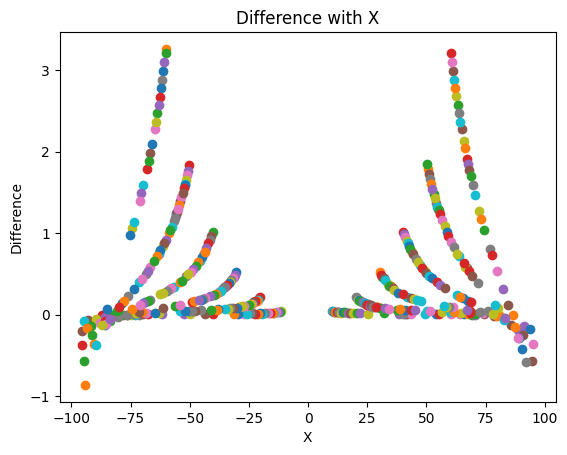

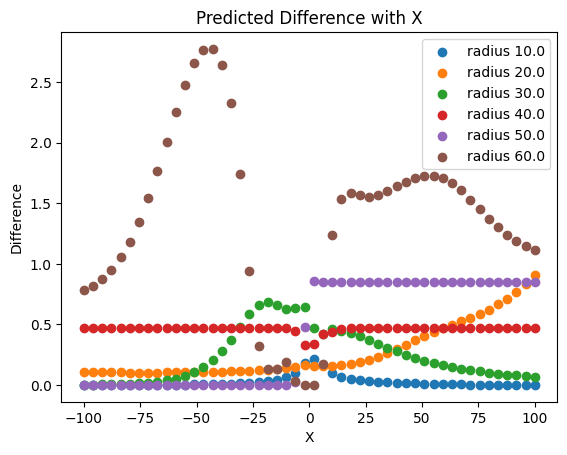

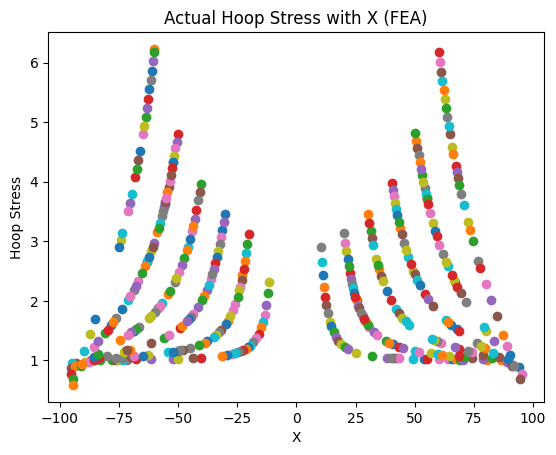

In [7]:
# combine all the x and FEA stress data
# this is needed for the looping logic of the model
# each radius has corresponding x and FEA hoop stress values
x = [x0, x1, x2, x3, x4, x5]
S22 = [S220, S221, S222, S223, S224, S225]
#define the different plots that will be part of the model
fig, ax = plt.subplots()
fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
fig3, ax3 = plt.subplots()
#loop through the values of the radii
#and the corresponding stress and c coordinates
etime = []
loss = []
for val1, val2, val3 in zip(a, x, S22):
  #define a list to store the difference for every passing loop
  diff = []
  #now loop through each individual x and stress values, for the current value
  #of radius
  for j, i in zip(val2, val3):
    #compute Kirsch's solution
    sigthetap = sigt(sigref, val1, j, theta)
    #plot Kirsch's solution as a function of x
    ax.scatter(j, sigthetap, label="radius" + str(val1))
    ax.set_ylabel("Hoop Stress")
    ax.set_xlabel("X")
    ax.set_title("Actual Hoop Stress with X (Analytical)")
    #plot the FEA stress against X
    ax3.scatter(j,i)
    ax3.set_ylabel("Hoop Stress")
    ax3.set_xlabel("X")
    ax3.set_title("Actual Hoop Stress with X (FEA)")
    #compute the difference and store it in the list defined above
    diffi = i - sigthetap
    diff.append(diffi)
    #plot the difference againt x
    ax1.scatter(j, diffi)
    ax1.set_ylabel("Difference")
    ax1.set_xlabel("X")
    ax1.set_title("Difference with X")

  #convert to an array to use in the model
  diff = np.array(diff)
  model = Sequential()

  # First split the data into a training set and a temporary set.
  val2_train, val2_temp, diff_train, diff_temp = train_test_split(val2, diff, test_size=0.3)

  # Then split the temp_set into a validation set and a testing set.
  val2_val, val2_test, diff_val, diff_test = train_test_split(val2_temp, diff_temp, test_size=0.5)

  # # Add L2 regularization and dropout for the hidden layers
  # model.add(Dense(units=3, activation='gelu', input_dim=1, kernel_regularizer=l2(0.01)))
  # model.add(Dropout(0.2))
  # model.add(Dense(units=6, activation='gelu', kernel_regularizer=l2(0.01)))
  # model.add(Dropout(0.2))
  # model.add(Dense(units=6, activation='gelu', kernel_regularizer=l2(0.01)))
  # model.add(Dropout(0.2))
  # model.add(Dense(units=6, activation='gelu', kernel_regularizer=l2(0.01)))
  # model.add(Dropout(0.2))

  # Add a layer of 3 nodes of GeLUs, taking two input parameters
  model.add(Dense(units=3, activation='gelu', input_dim=1))

  # Add a linear node at the end to combine the nodes together
  model.add(Dense(units=6, activation='gelu'))

  # Add a linear node at the end to combine the nodes together
  model.add(Dense(units=6, activation='gelu'))

  # Add a linear node at the end to combine the nodes together
  model.add(Dense(units=6, activation='gelu'))


  # Add the final output layer with the 'softplus' activation function
  model.add(Dense(units=1, activation='softplus'))

  #learning rate
  optimizer = Adam(lr=0.001)

  # Compile the model
  model.compile(loss="mean_squared_error", optimizer=optimizer)

  start_time = time.time()

  # Fit the data 
  # Include validation data
  history = model.fit(val2_train, diff_train, epochs=400, batch_size=12, validation_data=(val2_val, diff_val))

  end_time = time.time()

  # Calculate execution time
  execution_time = end_time - start_time
  etime.append(execution_time)

  # Evaluate the model on the test set
  test_loss = model.evaluate(val2_test, diff_test, verbose=0)
  loss.append(test_loss)

  #generate some test data
  xtest = np.linspace(-100,100,50)
  #predict difference using the model
  y_pred = model.predict(xtest)
  #plot the prediction
  ax2.scatter(xtest, y_pred, label="radius "+str(val1))
  ax2.set_ylabel("Difference")
  ax2.set_xlabel("X")
  ax2.set_title("Predicted Difference with X")
  ax2.legend()






    




In [8]:
training_time = sum(etime)
total_loss = sum(loss)/len(loss)
print(f"Execution time per radius: {etime} seconds")
print(f"Test loss per radius: {loss}")
print(f"Total Execution time: {training_time} seconds")
print(f"Average Test loss: {total_loss}")


Execution time per radius: [22.489799976348877, 18.703164100646973, 21.131800174713135, 21.773929357528687, 42.09697103500366, 19.282212495803833] seconds
Test loss per radius: [0.0006278853979893029, 0.12548433244228363, 0.0023906261194497347, 0.16753073036670685, 0.6912475228309631, 0.43976256251335144]
Total Execution time: 145.47787714004517 seconds
Average Test loss: 0.23784060994512402
